# Cuaderno de Clasificación

En este cuaderno se encuentra el material expositivo para la clase de clasificación. Se realizará la explicación con tres tipos de modelos para que los estudiantes puedan aplicar cualquiera de ellos en los ejercicios del taller del final de la lección.

## Sección 1: Máquinas de vectores de soporte (SVM)
Las máquinas de vectores de soporte tienen algunas ventajas como son:
- Son efectivas cuando el número de dimensiones es mayor que el número de muestras
- Son aplicables en espacios de alta dimensionalidad
- Son versátiles, varios kernels se pueden emplear en un problema tanto de clasificación como de regresión.
- Usan eficientemente la memoria ya que se basan en un número de características para realizar la clasificación.

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris

### 1.1 Carga y análisis exploratorio del dataset Iris
Uno de los principales usos del dataset Iris es la clasificación. A partir de los datos medidos pretendemos clasificar la especie a la que pertenece una flor, dentro de tres categorías previamente definidas (setosa, virgínica y versicolor)

In [2]:
iris = pd.read_csv('C:/Users/jhinn/Downloads/iris.data', names=["SepalLengthCm",
                                                      "SepalWidthCm",
                                                      "PetalLengthCm",
                                                      "PetalWidthCm",
                                                      "Species"])
iris.describe() #

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


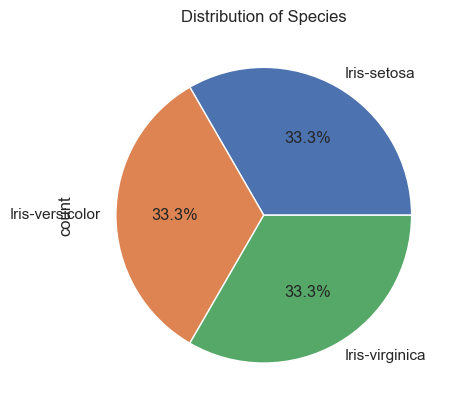

In [3]:
svm_palette = ['#3d5a80', '#98c1d9', '#ee6c4d', '#293241']
plt.title("Distribution of Species")
iris['Species'].value_counts().plot.pie(autopct="%1.1f%%");



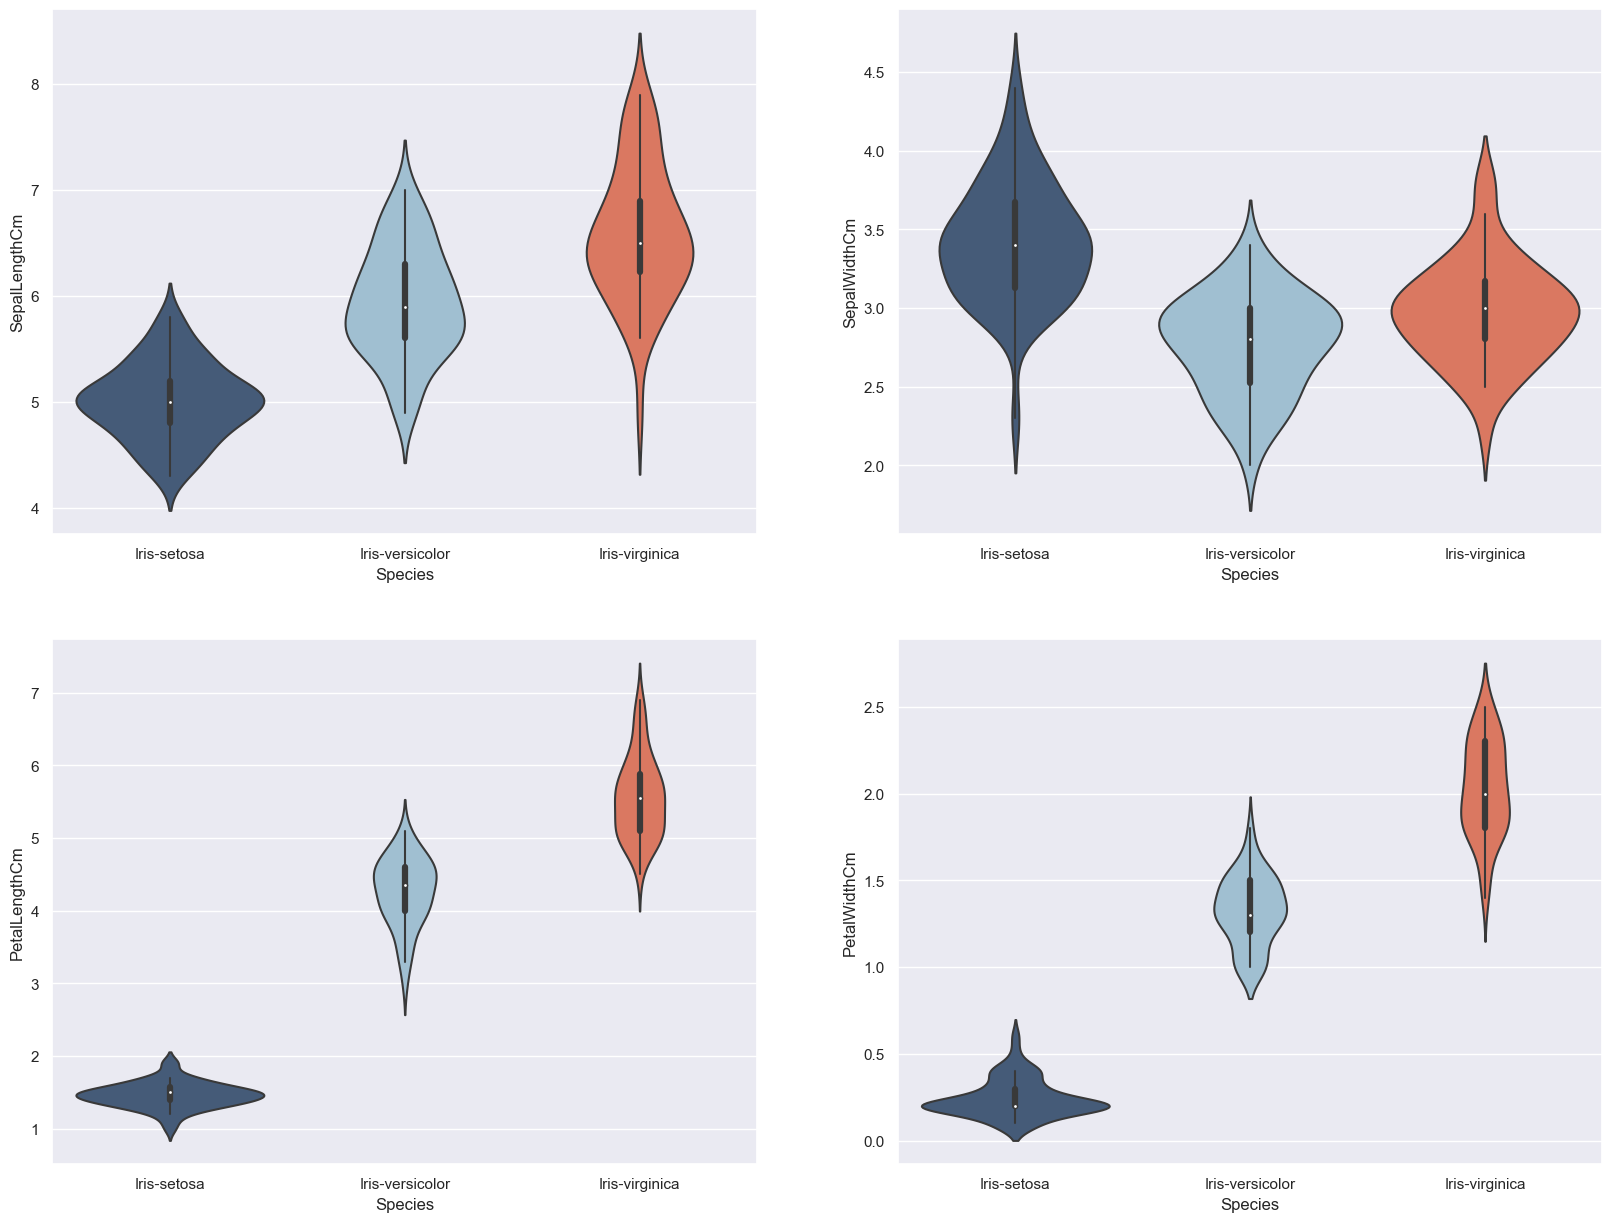

In [4]:
# Analizando las medidas de las flores en diagramas de violín
plt.figure(figsize=(20,15))
sns.set_style('darkgrid')
plt.subplot(2,2,1)
sns.violinplot(x = 'Species', y = 'SepalLengthCm', data = iris, palette=svm_palette)
plt.subplot(2,2,2)
sns.violinplot(x = 'Species', y = 'SepalWidthCm', data = iris, palette=svm_palette)
plt.subplot(2,2,3)
sns.violinplot(x = 'Species', y = 'PetalLengthCm', data = iris, palette=svm_palette)
plt.subplot(2,2,4)
sns.violinplot(x = 'Species', y = 'PetalWidthCm', data = iris, palette=svm_palette);


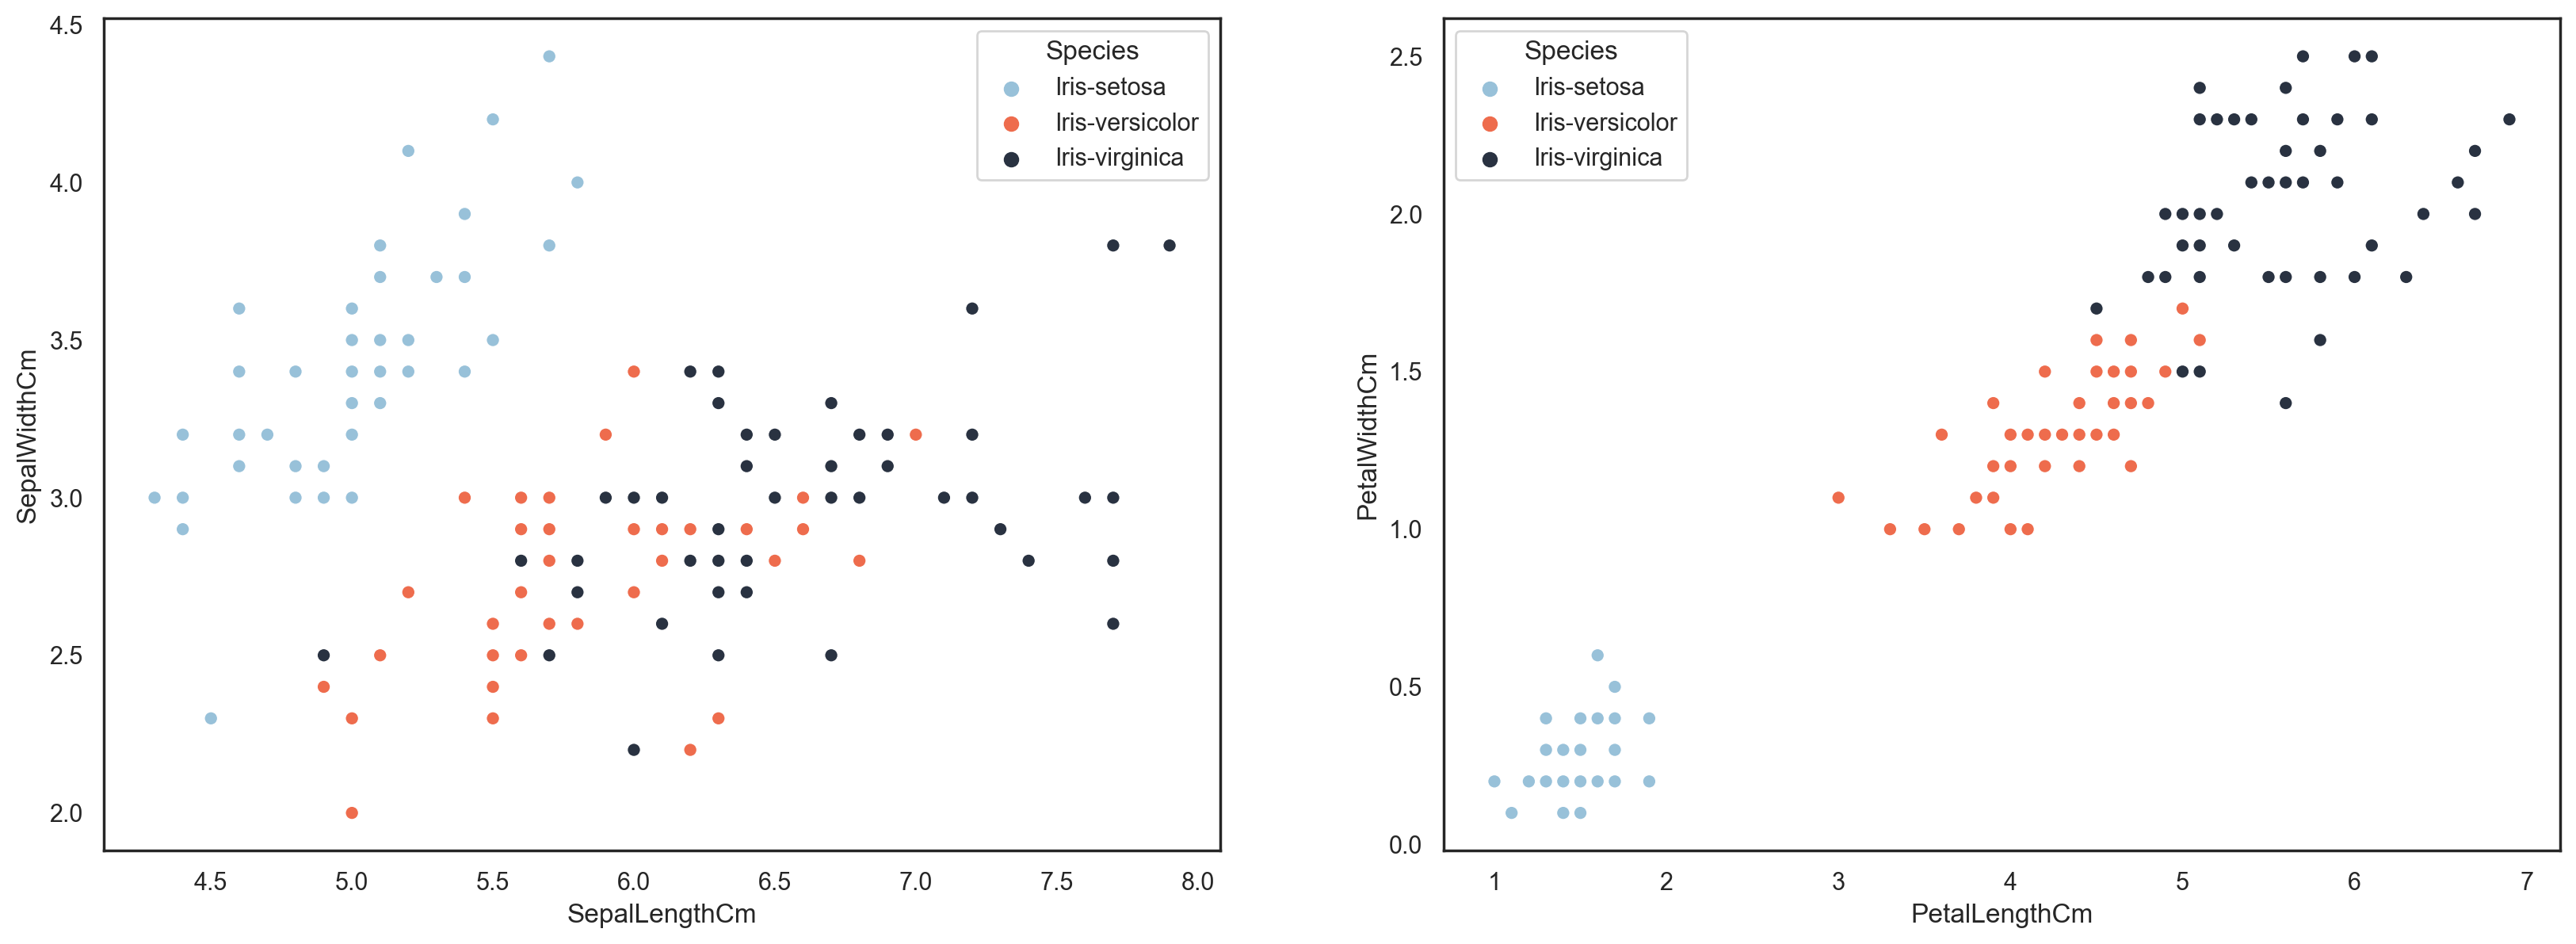

In [5]:
# Visualizando las características en un análisis multivariado, en este caso graficaremos sepalo (ancho y alto)  y pétalo (ancho y alto)
plt.figure(figsize=(20,15), dpi = 200)
sns.set_style('white')
plt.subplot(2,2,1)
sns.scatterplot(x = 'SepalLengthCm', y = 'SepalWidthCm', hue = 'Species', data = iris, palette=svm_palette[1:])
plt.subplot(2,2,2)
sns.scatterplot(x = 'PetalLengthCm', y = 'PetalWidthCm', hue = 'Species', data = iris, palette=svm_palette[1:]);
# como se vio en los gráficos de violín, la especie iris setosa es linealmente separable, es decir, trazando una recta sobre el plano es posible clasificar si una flor pertenece a esta especie.

c:\Users\jhinn\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


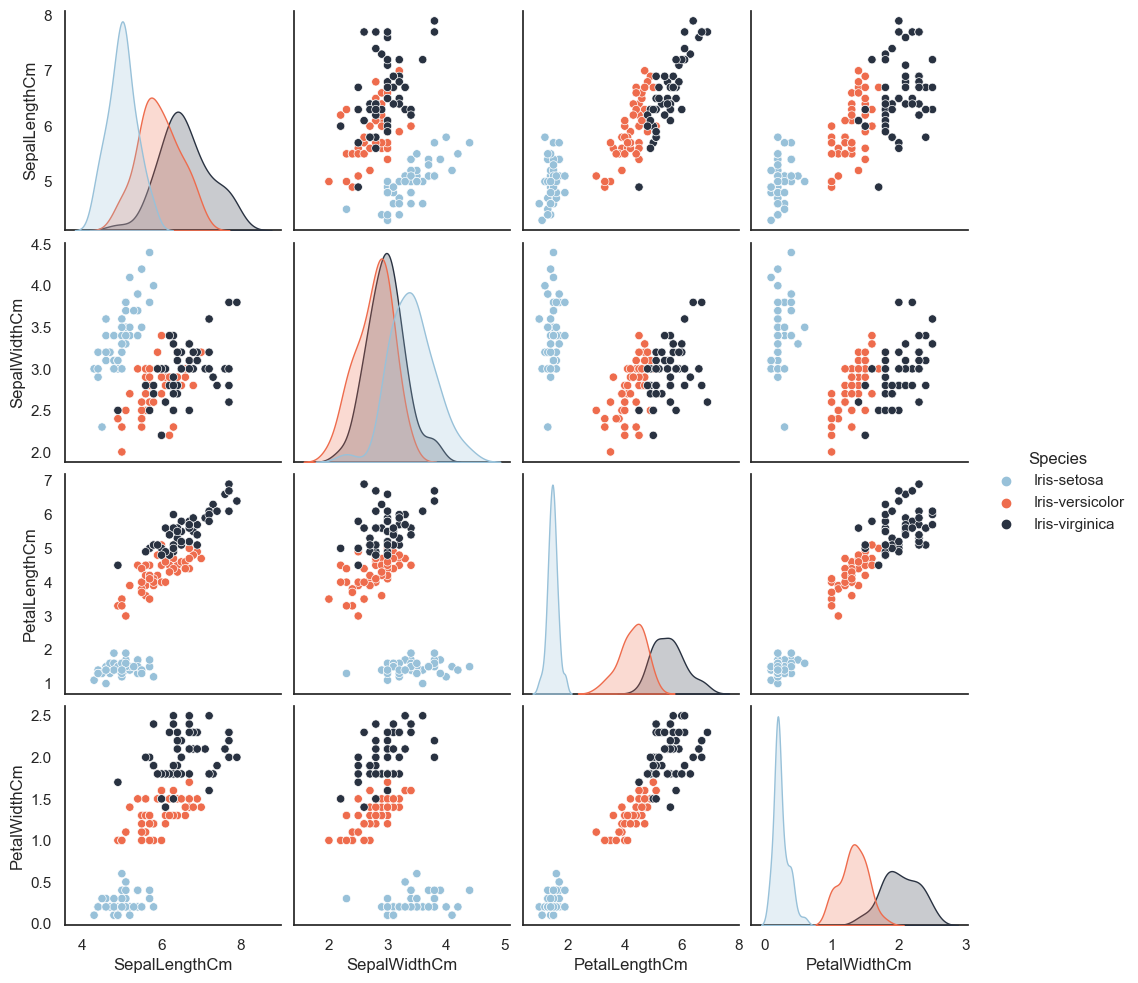

In [6]:
sns.pairplot(iris, hue = 'Species', vars = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], palette=svm_palette[1:] );

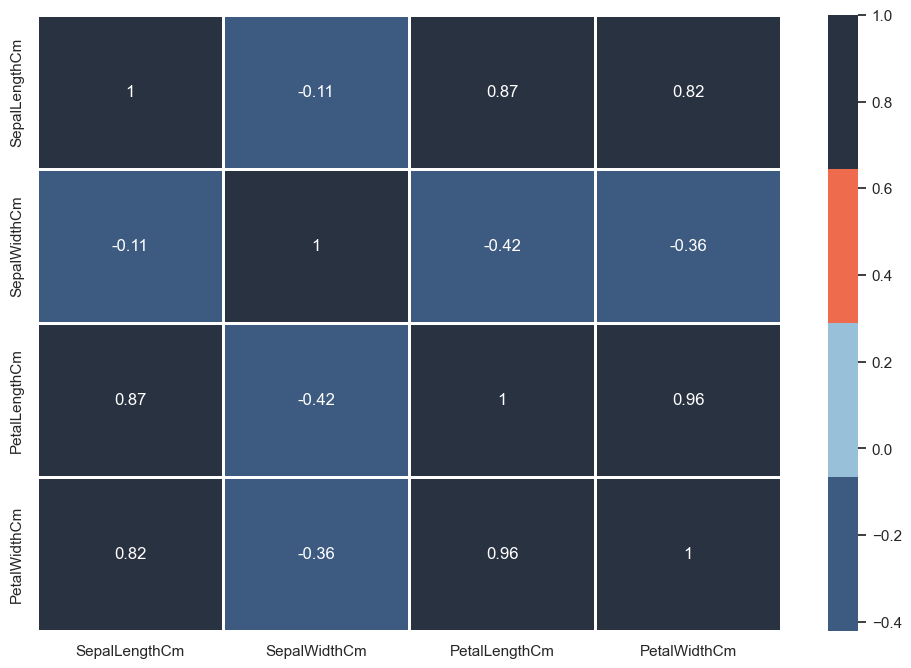

In [7]:
# revisando la correlación entre las variables
iris_features = iris.drop("Species", axis=1) # eliminando la columna con nombres
plt.figure(figsize=(12,8))
sns.heatmap(iris_features.corr(), annot=True, cmap=svm_palette, linewidths = 2) # calcular correlación y graficar como mapa de calor
plt.show()

## 1.2 Preparando los datos para entrenar modelos
En la etapa de preparación de los datos crearemos una partición para tener un conjunto de datos de entrenamiento y un conjunto de datos de validación.


In [8]:
X = iris.iloc[:, 0:4] # X seran todas las filas con las columnas de la 0 a la 4 (anchos y altos)
y = iris.iloc[:, 4:] # y seran los nombres de las especies (etiquetas de clasificación)

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 101)

print(f'Número total de muestras en el dataset: {len(X)}')
print("*****"*10)
print(f'Muestras para entrenamiento: {len(X_train)}')
print(f'Tamaño de X_train: {X_train.shape}')
print("*****"*10)
print(f'Muestras para validación: {len(X_test)}')
print(f'Tamaño de X_test: {X_test.shape}')

Número total de muestras en el dataset: 150
**************************************************
Muestras para entrenamiento: 97
Tamaño de X_train: (97, 4)
**************************************************
Muestras para validación: 53
Tamaño de X_test: (53, 4)


In [9]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
# Una buena práctica es ajustar los datos para que tengan media cero y varianza uno. Es decir, alteramos linealmente los datos para que estén escalados entre -1 y 1 de tal forma que el entrenamiento de los modelos sea más rápido y mas estable numéricamente. Con esto se evitan problemas de explosión de gradientes.
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 2. Empleando modelos de clasificación con los datos preparados
Ya que se han pre procesado los datos y calculado sus características, procedemos a crear modelos que permitan resolver el problema de clasificación.

### 2.1 SVMs


In [10]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)

train_score = model.score(X_train, y_train)
print(f'Train score of trained model: {train_score*100}')

test_score = model.score(X_test, y_test)
print(f'Test score of trained model: {test_score*100}')

Train score of trained model: 96.90721649484536
Test score of trained model: 98.11320754716981


c:\Users\jhinn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confussion Matrix: 
[[16  0  0]
 [ 0 22  0]
 [ 0  1 14]]



<Axes: >

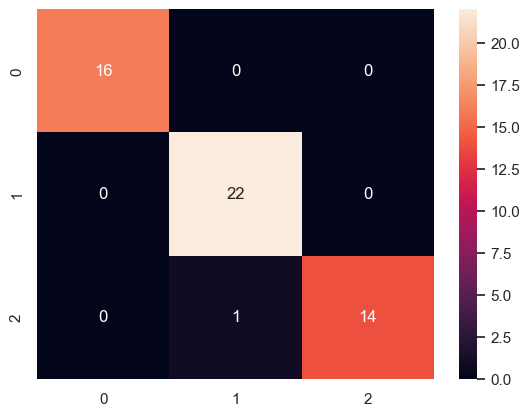

In [11]:
# Una forma de medir el desempeño de un modelo de clasificación es mediante el uso de la matriz de confusión que ayuda a saber qué tan bien fueron clasificados los datos
# en la matriz de confusion se saben cuantos fueron verdaderos positivos y verdaderos negativos (clasificaciones correctas)
# falsos positivos y falsos negativos (clasificaciones incorrectas).
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(pred, y_test)
print(f'Confussion Matrix: \n{conf_matrix}\n')
sns.heatmap(conf_matrix, annot=True)



In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       1.00      0.96      0.98        23
 Iris-virginica       0.93      1.00      0.97        14

       accuracy                           0.98        53
      macro avg       0.98      0.99      0.98        53
   weighted avg       0.98      0.98      0.98        53



## 2.2 KNN


In [13]:
# ya que las etiquetas son categorías, para knn hay que preprocesarlas ya que el modelo no acepta strings como etiquetas, hay que codificarlas
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
yknn = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(yknn), test_size = 0.35, random_state = 101)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Instantiate learning model (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Fitting the modelç
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

c:\Users\jhinn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[16,  0,  0],
       [ 0, 23,  0],
       [ 0,  0, 14]], dtype=int64)

In [15]:
# calculando métricas del modelo
accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')
# si bien los datos de test dan el 100% de precisión, pero pudiera ser que el modelo esté sobre entrenado o que los datos sean fácilmente separables
# teniendo en cuenta el análisis previo relaizado, sabemos que se pueden separar las especies por sus características. Sin embargo, siempre es sospechoso un rendimiento del 100% en un modelo entrnado

Accuracy of our model is equal 100.0 %.


## 2.3 Regresión logística

In [16]:
# Para el caso de la regresión logística tenemos que procesar las etiquetas de entrada como números, este modelo no puede obtener como entrada 'Iris-setosa' por lo que se necesita reemplazar por un número
iris["target"] = iris["Species"].map({"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2,})
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,target
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [17]:
# separando el dataset
X = iris.iloc[:, [0, 1, 2, 3]].values
y = iris.iloc[:, 5].values
# preprocesando los datos para que tengan media cero y desviación de uno
sc = StandardScaler()
X = sc.fit_transform(X)
# particionando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [18]:
# Ajustando el modelo
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', multi_class="auto")
classifier.fit(X_train, y_train)

LogisticRegression()

In [19]:
# predicioendo los resultados
y_pred = classifier.predict(X_test)
probs_y = classifier.predict_proba(X_test) # mirando las probabilidades de las predicciones

# Imprimiendo los resultados de la clasificación del modelo:
probs_y = np.round(probs_y, 2)
res = "{:<10} | {:<10} | {:<10} | {:<13} | {:<5}".format("y_test", "y_pred", "Setosa(%)", "versicolor(%)", "virginica(%)\n")
res += "-"*65+"\n"
res += "\n".join("{:<10} | {:<10} | {:<10} | {:<13} | {:<10}".format(x, y, a, b, c) for x, y, a, b, c in zip(y_test, y_pred, probs_y[:,0], probs_y[:,1], probs_y[:,2]))
res += "\n"+"-"*65+"\n"
print(res)

y_test     | y_pred     | Setosa(%)  | versicolor(%) | virginica(%)
-----------------------------------------------------------------
2          | 2          | 0.0        | 0.29          | 0.71      
2          | 2          | 0.0        | 0.21          | 0.79      
2          | 2          | 0.0        | 0.16          | 0.84      
1          | 1          | 0.09       | 0.84          | 0.07      
2          | 2          | 0.0        | 0.06          | 0.94      
1          | 1          | 0.02       | 0.79          | 0.19      
0          | 0          | 1.0        | 0.0           | 0.0       
0          | 0          | 0.95       | 0.05          | 0.0       
0          | 0          | 0.98       | 0.02          | 0.0       
2          | 2          | 0.0        | 0.2           | 0.8       
2          | 2          | 0.0        | 0.19          | 0.81      
2          | 2          | 0.0        | 0.02          | 0.98      
0          | 0          | 0.97       | 0.03          | 0.0       
0       

In [20]:
# Evaluando matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10  0  0]
 [ 0 11  2]
 [ 0  0 15]]


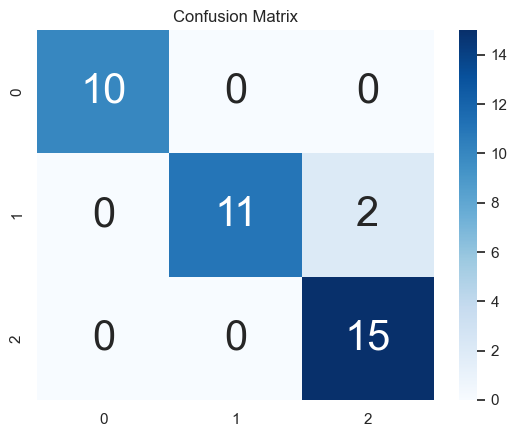

In [21]:
ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

In [22]:

modelos=[]

modelos.append(('LR',LogisticRegression(solver='lbfgs',multi_class='auto')))
modelos.append(('KNN',KNeighborsClassifier(n_neighbors=3)))
modelos.append(('SVM',SVC(kernel='rbf',probability=True)))



In [23]:
from sklearn.model_selection import StratifiedKFold

resultados=[]
nombres=[]


for nombre,modelo in modelos:
    kfold=StratifiedKFold(n_splits=10, random_state=12,shuffle=True)
    cv_results=cross_val_score(modelo,X_train,y_train,cv=kfold,scoring='accuracy')
    resultados.append(cv_results)
    nombres.append(nombre)
    print('%s: %f (%f)' % (modelo, cv_results.mean(), cv_results.std())) 

LogisticRegression(): 0.964394 (0.043658)
KNeighborsClassifier(n_neighbors=3): 0.954545 (0.045455)
SVC(probability=True): 0.964394 (0.043658)
